In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.getcwd()

'C:\\Users\\TemwekaC\\Desktop\\Udacity\\Course 1\\Project 1'

In [3]:
books = pd.read_csv('goodreads_books.csv')
books.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


Removig columns that are not useful 

In [4]:
remove_col = ['link','cover_link', 'author_link', 'isbn13', 'isbn', 'asin', 'amazon_redirect_link', 'worldcat_redirect_link', 'recommended_books', 'books_in_series', 'description']
books = books.drop(columns = remove_col)

In [5]:
books.head()

,id,title,series,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,date_published,publisher,original_title,genre_and_votes,settings,characters,awards
0,630104,Inner Circle,(Private #5),"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,220.0,January 1st 2007,Simon Schuster Books for Young Readers,Inner Circle,"Young Adult 161, Mystery 45, Romance 32",NaN,NaN,NaN
1,9487,A Time to Embrace,(Timeless Love #2),Karen Kingsbury,4179,177,4.35,2255,1290,518,93,23,400.0,October 29th 2006,Thomas Nelson,NaN,"Christian Fiction 114, Christian 45, Fiction 3...",NaN,NaN,NaN
2,6050894,Take Two,(Above the Line #2),Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,320.0,January 1st 2009,Zondervan,Take Two,"Christian Fiction 174, Christian 81, Fiction 58","Bloomington, Indiana(United States)",NaN,NaN
3,39030,Reliquary,(Pendergast #2),"Douglas Preston, Lincoln Child",38382,1424,4.01,12711,15407,8511,1429,324,464.0,1997,Tor Books,Reliquary,"Thriller 626, Mystery 493, Horror 432, Fiction...","New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,NaN,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,258.0,October 28th 1995,Gallery Books,The Millionaire Next Door: The Surprising Secr...,"Economics-Finance 1162, Nonfiction 910, Busine...",NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...


In [119]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52128 entries, 0 to 52198
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  52128 non-null  int64  
 1   title               52128 non-null  object 
 2   series              23311 non-null  object 
 3   author              52128 non-null  object 
 4   rating_count        52128 non-null  int64  
 5   review_count        52128 non-null  int64  
 6   average_rating      52128 non-null  float64
 7   five_star_ratings   52128 non-null  int64  
 8   four_star_ratings   52128 non-null  int64  
 9   three_star_ratings  52128 non-null  int64  
 10  two_star_ratings    52128 non-null  int64  
 11  one_star_ratings    52128 non-null  int64  
 12  number_of_pages     49821 non-null  float64
 13  date_published      51278 non-null  object 
 14  publisher           48509 non-null  object 
 15  original_title      39228 non-null  object 
 16  genr

Removing rows with no ratings

In [6]:
books = books[~books.rating_count.isin([0])]

Creating a dataframe to that focuses on the numerical values only

In [7]:
books_num = books[['rating_count', 'review_count', 'average_rating', 'five_star_ratings', 'four_star_ratings','three_star_ratings', 
       'two_star_ratings', 'one_star_ratings', 'number_of_pages']]

In [8]:
books_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52128 entries, 0 to 52198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating_count        52128 non-null  int64  
 1   review_count        52128 non-null  int64  
 2   average_rating      52128 non-null  float64
 3   five_star_ratings   52128 non-null  int64  
 4   four_star_ratings   52128 non-null  int64  
 5   three_star_ratings  52128 non-null  int64  
 6   two_star_ratings    52128 non-null  int64  
 7   one_star_ratings    52128 non-null  int64  
 8   number_of_pages     49821 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 4.0 MB


Filling in missing values with the mean values

In [9]:
books_num = books_num.fillna(books_num.mean())

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

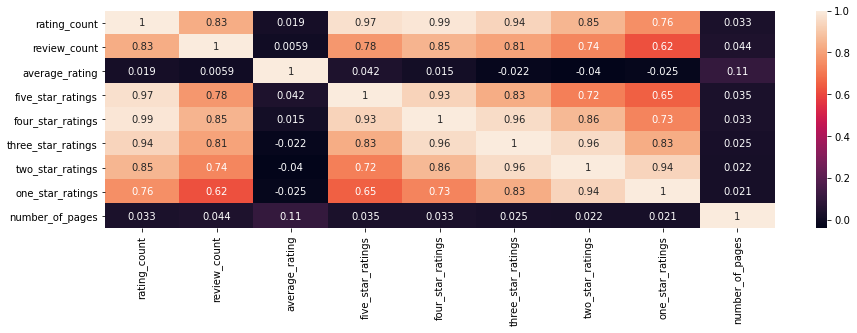

In [11]:
plt.figure(figsize=(15,4))
corr_matrix = books_num.corr()
sns.heatmap(corr_matrix, annot=True)

Text(0.5, 1.0, 'Distribution of number of pages of books with less than 1000pages')

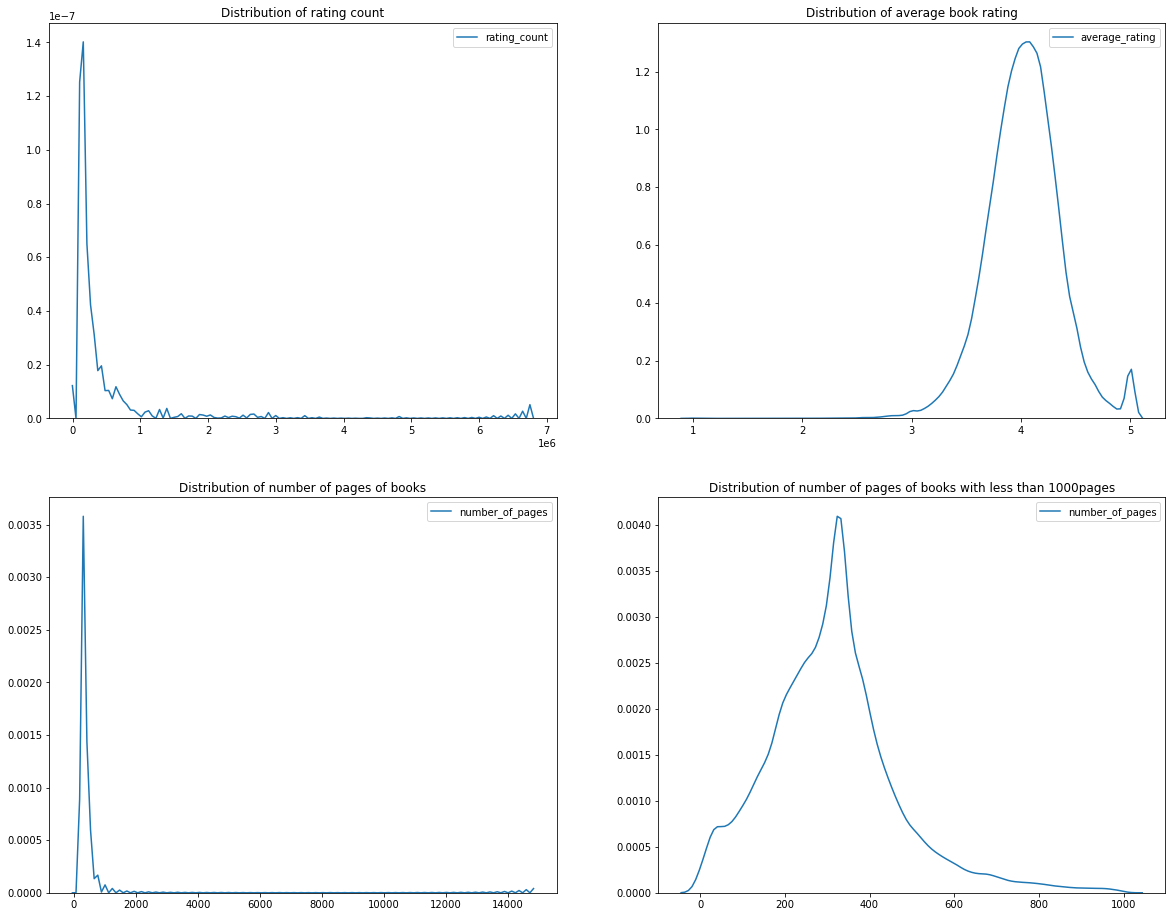

In [59]:
# DISTRIBUTION PLOTS

fig, axes = plt.subplots(2, 2, figsize=(20,16))

plt1 = sns.kdeplot(books_num["rating_count"], ax=axes[0,0])
plt1.set_title("Distribution of rating count") 

plt2 = sns.kdeplot(books_num["average_rating"], ax=axes[0,1])
plt2.set_title("Distribution of average book rating")
plt.savefig('average_rating.png')

plt3 = sns.kdeplot(books_num['number_of_pages'], ax=axes[1,0])
plt3.set_title("Distribution of number of pages of books")

plt4 = sns.kdeplot(books_num[books_num['number_of_pages'] < 1000]["number_of_pages"], ax=axes[1,1])
plt4.set_title("Distribution of number of pages of books with less than 1000pages")


In [13]:
five_star_books = books_num[books_num['average_rating'] == 5]

In [14]:
five_star_books.mean()

rating_count            3.589835
review_count            0.940898
average_rating          5.000000
five_star_ratings       3.588652
four_star_ratings       0.001182
three_star_ratings      0.000000
two_star_ratings        0.000000
one_star_ratings        0.000000
number_of_pages       220.169092
dtype: float64

In [15]:
five_star_books.max()

rating_count           375.0
review_count            17.0
average_rating           5.0
five_star_ratings      374.0
four_star_ratings        1.0
three_star_ratings       0.0
two_star_ratings         0.0
one_star_ratings         0.0
number_of_pages       3357.0
dtype: float64

In [16]:
five_star_books[five_star_books['rating_count'] == 375]

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages
44353,375,15,5.0,374,1,0,0,0,50.0


In [18]:
books.loc[44353,"title"]

"The Devil's Deceptions: Is There Life After Death?"

In [19]:
five_star_books[five_star_books['review_count'] == 17]

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages
12217,23,17,5.0,23,0,0,0,0,153.0


In [20]:
books.loc[12217,["title","author"]]

title     The Right Person
author     Stacy A. Padula
Name: 12217, dtype: object

In [21]:
five_star_books.describe()

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages
count,846.000000,846.000000,846.0,846.000000,846.000000,846.0,846.0,846.0,846.000000
mean,3.589835,0.940898,5.0,3.588652,0.001182,0.0,0.0,0.0,220.169092
std,13.257606,1.730015,0.0,13.224455,0.034381,0.0,0.0,0.0,200.497603
min,1.000000,0.000000,5.0,1.000000,0.000000,0.0,0.0,0.0,0.000000
25%,1.000000,0.000000,5.0,1.000000,0.000000,0.0,0.0,0.0,87.000000
50%,2.000000,0.000000,5.0,2.000000,0.000000,0.0,0.0,0.0,198.000000
75%,4.000000,1.000000,5.0,4.000000,0.000000,0.0,0.0,0.0,329.072600
max,375.000000,17.000000,5.0,374.000000,1.000000,0.0,0.0,0.0,3357.000000


Text(0.5, 1.0, 'Distribution of rating count of five star books')

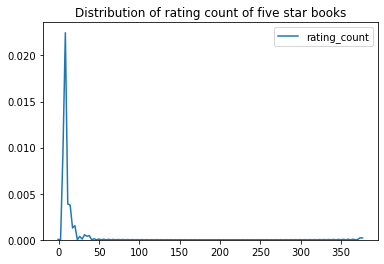

In [23]:
plt1 = sns.kdeplot(five_star_books["rating_count"])
plt1.set_title("Distribution of rating count of five star books") 

In [25]:
books_num.describe()

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages
count,5.212800e+04,52128.000000,52128.000000,5.212800e+04,5.212800e+04,52128.000000,52128.000000,52128.000000,52128.00000
mean,1.889932e+04,1014.360555,4.026086,7.827823e+03,6.259299e+03,3461.220304,936.770776,414.203442,329.07260
std,1.164750e+05,4057.390463,0.336069,5.880303e+04,3.475821e+04,18261.276538,5893.985906,3845.942708,247.17001
min,1.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000
25%,3.440000e+02,32.000000,3.820000,1.190000e+02,1.100000e+02,64.000000,16.000000,6.000000,217.00000
50%,2.303000e+03,163.000000,4.030000,8.130000e+02,7.680000e+02,454.000000,108.000000,36.000000,312.00000
75%,9.315250e+03,623.250000,4.230000,3.381250e+03,3.198000e+03,1869.250000,450.000000,152.000000,386.00000
max,6.801077e+06,169511.000000,5.000000,4.414877e+06,1.868421e+06,980183.000000,529060.000000,537793.000000,14777.00000


In [26]:
books_num.loc[:,'proportional_five_stars'] = books_num['five_star_ratings']/books_num['rating_count']

In [27]:
books_num.loc[:,'review_rating_ratio'] = books_num['review_count']/books_num['rating_count']

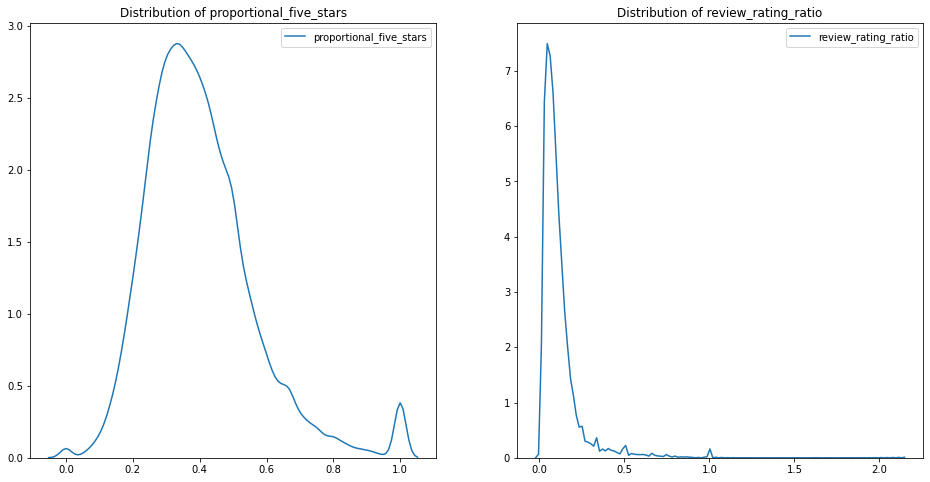

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

plt4 = sns.kdeplot(books_num['proportional_five_stars'], ax=axes[0])
plt4.set_title("Distribution of proportional_five_stars")


plt5 = sns.kdeplot(books_num['review_rating_ratio'], ax=axes[1])
plt5.set_title("Distribution of review_rating_ratio")

plt.savefig('sample.png')

In [29]:
books_num.head()

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,proportional_five_stars,review_rating_ratio
0,7597,196,4.03,3045,2323,1748,389,92,220.0,0.400816,0.025800
1,4179,177,4.35,2255,1290,518,93,23,400.0,0.539603,0.042355
2,6288,218,4.23,3000,2020,1041,183,44,320.0,0.477099,0.034669
3,38382,1424,4.01,12711,15407,8511,1429,324,464.0,0.331171,0.037101
4,72168,3217,4.04,27594,25219,14855,3414,1086,258.0,0.382358,0.044577


In [30]:
books_num.describe()

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,proportional_five_stars,review_rating_ratio
count,5.212800e+04,52128.000000,52128.000000,5.212800e+04,5.212800e+04,52128.000000,52128.000000,52128.000000,52128.00000,52128.000000,52128.000000
mean,1.889932e+04,1014.360555,4.026086,7.827823e+03,6.259299e+03,3461.220304,936.770776,414.203442,329.07260,0.400729,0.110675
std,1.164750e+05,4057.390463,0.336069,5.880303e+04,3.475821e+04,18261.276538,5893.985906,3845.942708,247.17001,0.162631,0.119250
min,1.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,3.440000e+02,32.000000,3.820000,1.190000e+02,1.100000e+02,64.000000,16.000000,6.000000,217.00000,0.290245,0.045977
50%,2.303000e+03,163.000000,4.030000,8.130000e+02,7.680000e+02,454.000000,108.000000,36.000000,312.00000,0.378050,0.080645
75%,9.315250e+03,623.250000,4.230000,3.381250e+03,3.198000e+03,1869.250000,450.000000,152.000000,386.00000,0.482451,0.130725
max,6.801077e+06,169511.000000,5.000000,4.414877e+06,1.868421e+06,980183.000000,529060.000000,537793.000000,14777.00000,1.000000,2.125000


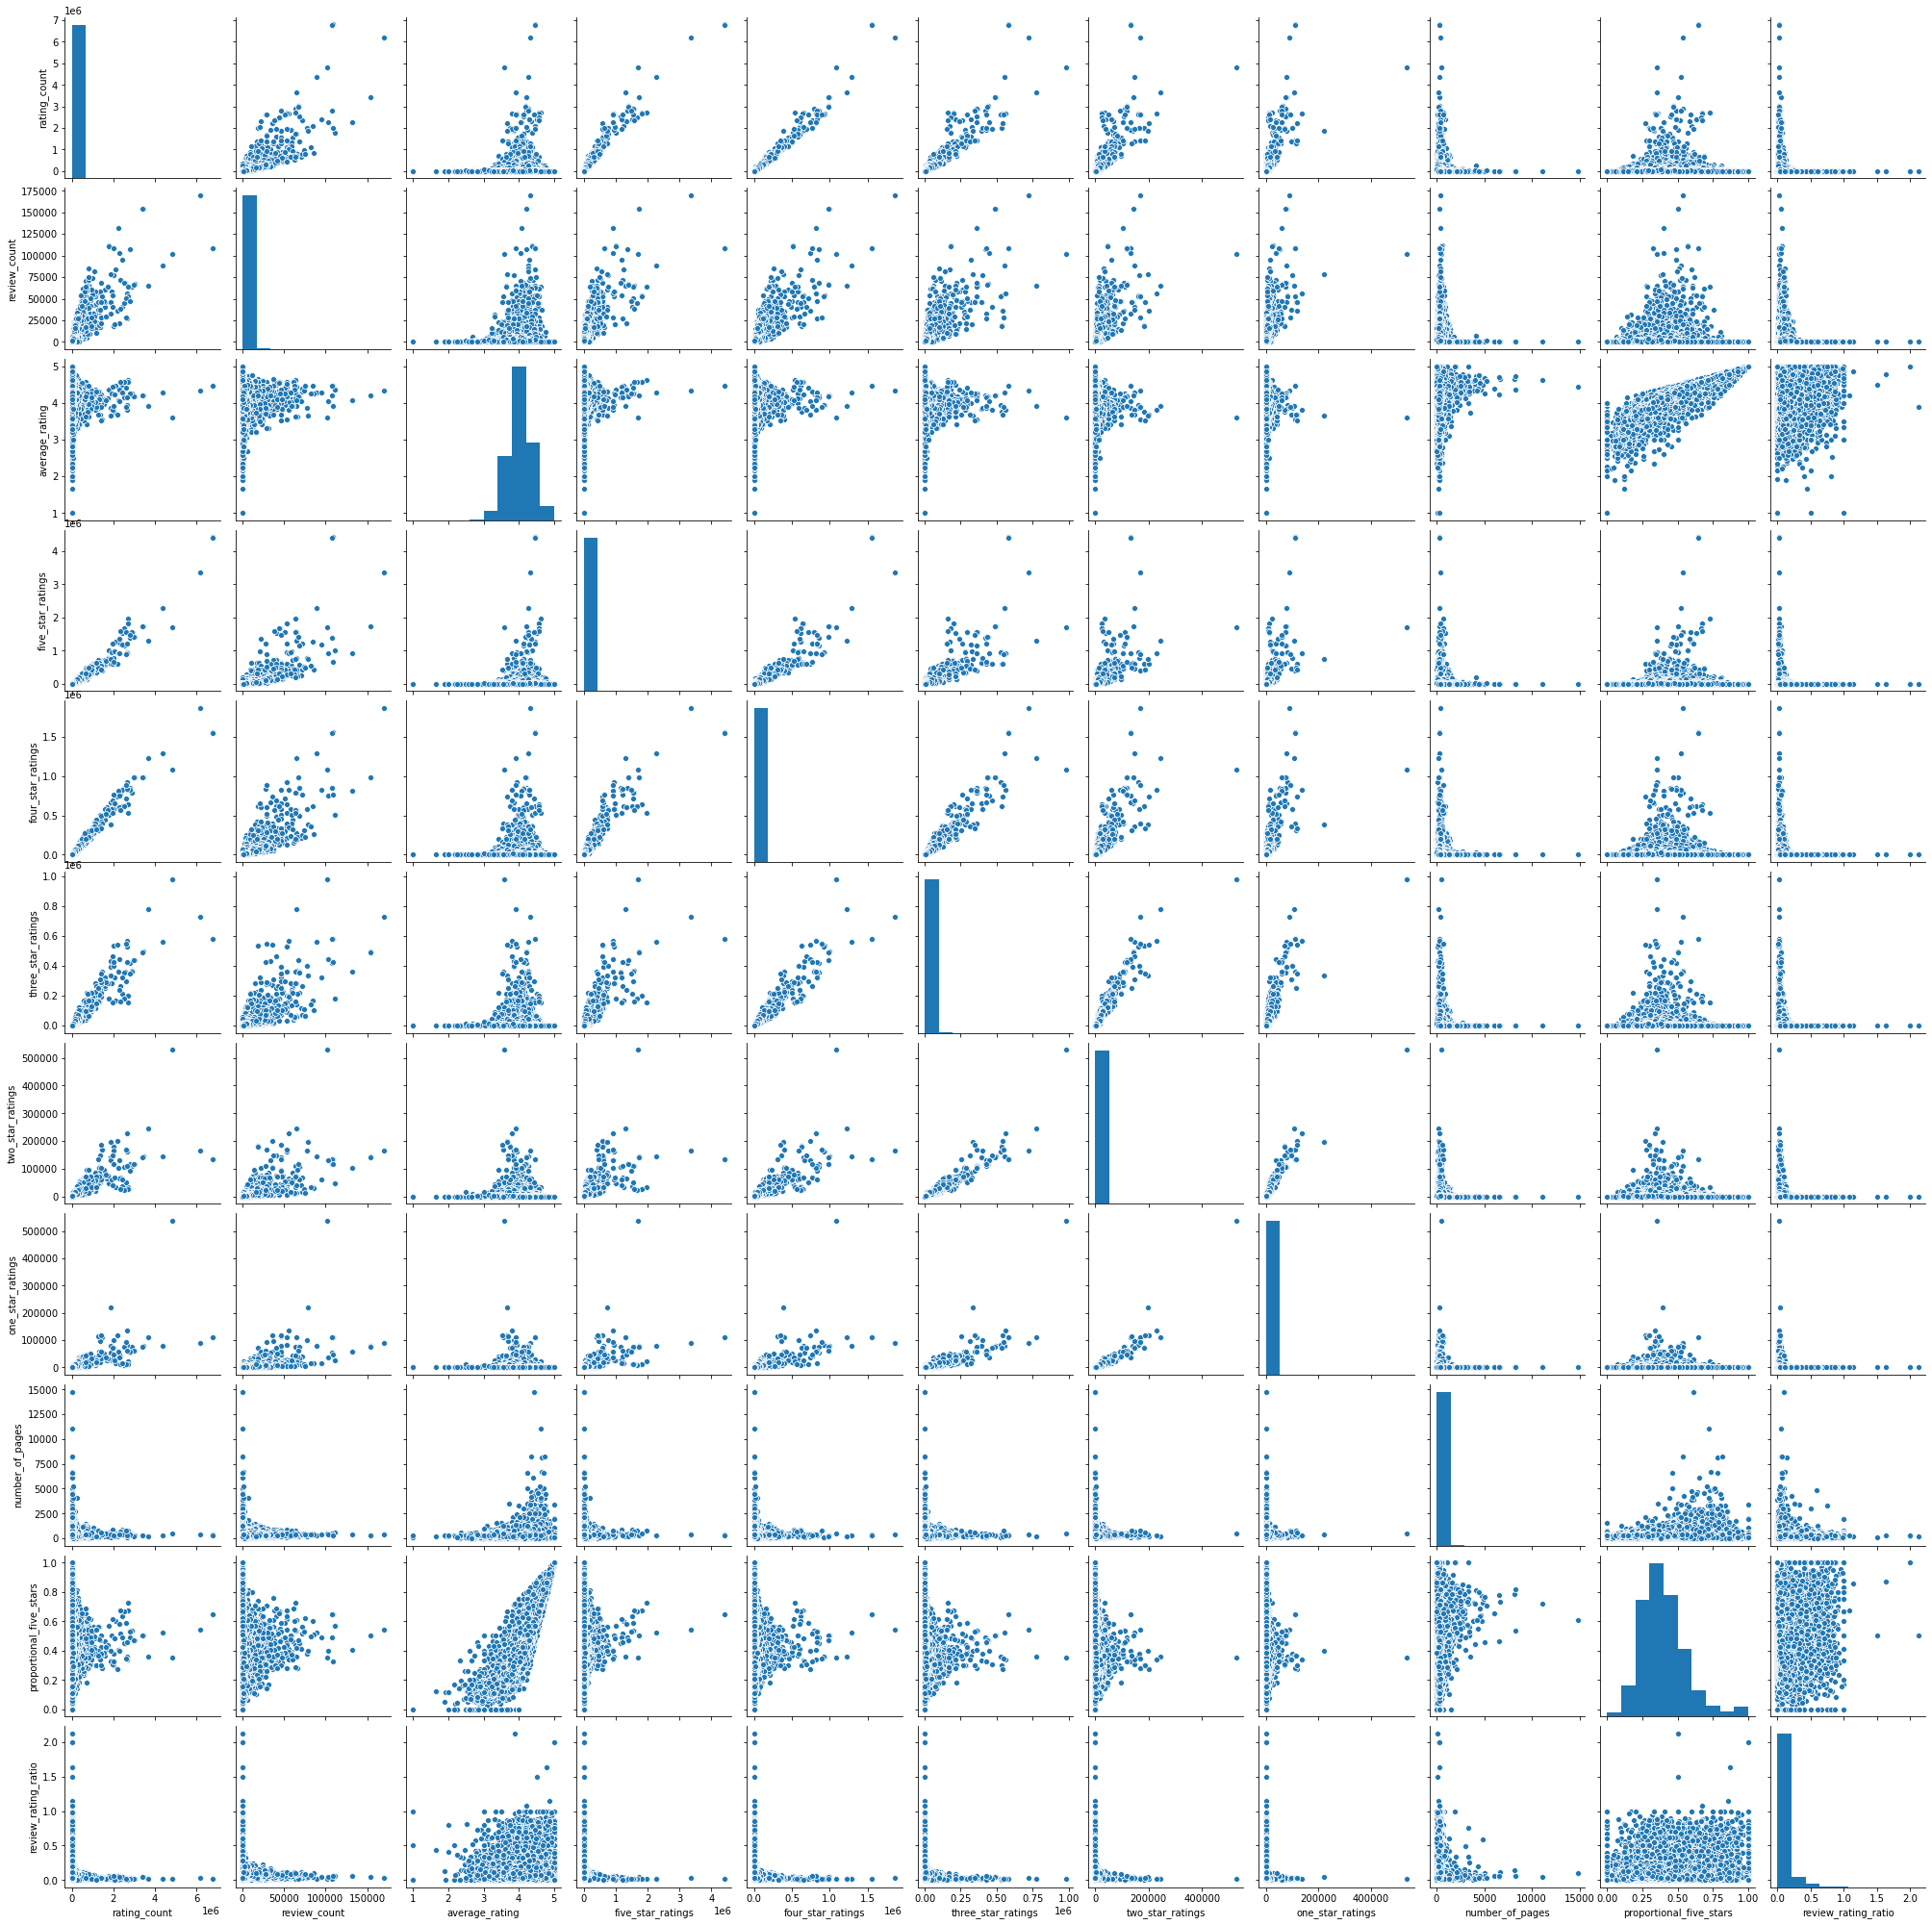

In [112]:
sns.pairplot(books_num)

In [31]:
books.head()

,id,title,series,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,date_published,publisher,original_title,genre_and_votes,settings,characters,awards
0,630104,Inner Circle,(Private #5),"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,220.0,January 1st 2007,Simon Schuster Books for Young Readers,Inner Circle,"Young Adult 161, Mystery 45, Romance 32",NaN,NaN,NaN
1,9487,A Time to Embrace,(Timeless Love #2),Karen Kingsbury,4179,177,4.35,2255,1290,518,93,23,400.0,October 29th 2006,Thomas Nelson,NaN,"Christian Fiction 114, Christian 45, Fiction 3...",NaN,NaN,NaN
2,6050894,Take Two,(Above the Line #2),Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,320.0,January 1st 2009,Zondervan,Take Two,"Christian Fiction 174, Christian 81, Fiction 58","Bloomington, Indiana(United States)",NaN,NaN
3,39030,Reliquary,(Pendergast #2),"Douglas Preston, Lincoln Child",38382,1424,4.01,12711,15407,8511,1429,324,464.0,1997,Tor Books,Reliquary,"Thriller 626, Mystery 493, Horror 432, Fiction...","New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,NaN,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,258.0,October 28th 1995,Gallery Books,The Millionaire Next Door: The Surprising Secr...,"Economics-Finance 1162, Nonfiction 910, Busine...",NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...


In [32]:
np.dtype(books['series'])

dtype('O')

In [33]:
type(books.iloc[3,2])

str

In [34]:
is_series = []

for i in range(len(books)):
    series = 1 if type(books.iloc[i,2]) == str else 0
    is_series.append(series)
    
print(is_series[0:5])

[1, 1, 1, 1, 0]


In [35]:
books['is_series'] = is_series

In [36]:
books.number_of_pages = books.number_of_pages.fillna(books.number_of_pages.mean())

In [37]:
import re

In [38]:
books['genre_and_votes'] = books['genre_and_votes'].replace(np.NaN, 'Unknown')

In [68]:
genres = []
for i, text in enumerate(books['genre_and_votes']):
    genre = re.split('\d',text,1)[0].rstrip()
    genre = re.split('-',genre,1)[0].rstrip()
    genres.append(genre)
    
print(genres[0:10])

['Young Adult', 'Christian Fiction', 'Christian Fiction', 'Thriller', 'Economics', 'Romance', 'Romance', 'Fiction', 'Sequential Art', 'Poetry']


In [69]:
len(np.unique(genres))

198

In [70]:
books['genre'] = genres

In [42]:
is_nominee = []

for i in range(len(books)):
    nominee = 1 if type(books.iloc[i,-3]) == str else 0
    is_nominee.append(nominee)
    
print(is_nominee[0:5])

[0, 0, 0, 0, 1]


In [43]:
books['is_nominated'] = is_nominee

In [82]:
import statistics
print(statistics.mode(books['genre']))
print(statistics.mode(books[books['genre']!= 'Fantasy']['genre']))

Fantasy
Fiction


In [72]:
print(len(books[books['genre'] == 'Fantasy']['genre']))
print(len(books[books['genre'] == 'Fiction']['genre']))

6977
6230


In [54]:
print(len(books[books['is_nominated'] == True]['is_nominated']))
print(statistics.mode(books['is_nominated']))
print(len(books[books['is_series'] == True]['is_series']))
print(statistics.mode(books['is_series']))

10626
0
23311
0


In [53]:
print(len(books['is_series']))

52128


In [87]:
mean_by_genre = books.groupby('genre').mean().sort_values("average_rating", ascending=False)[['average_rating','number_of_pages', 'rating_count','review_count','is_series', 'is_nominated']]

In [85]:
sum_by_genre = books.groupby('genre').sum().sort_values('rating_count', ascending=False)[['rating_count','review_count','is_series', 'is_nominated']]

In [113]:
mean_by_genre.head(10)

,average_rating,number_of_pages,rating_count,review_count,is_series,is_nominated
genre,,,,,,
Computers,5.000000,50.0000,2.000000,0.000000,0.000000,0.000000
Biblical Fiction,4.676667,133.0000,564.666667,124.333333,0.333333,0.666667
Neuroscience,4.670000,672.0000,9.000000,1.000000,0.000000,0.000000
Soccer,4.580000,288.0000,12.000000,0.000000,0.000000,0.000000
Pornography,4.570000,329.0726,7.000000,2.000000,0.000000,0.000000
United States,4.500000,303.0000,4.000000,0.000000,0.000000,1.000000
Gender,4.500000,352.0000,2.000000,0.000000,0.000000,0.000000
Artificial Intelligence,4.490000,233.0000,25.500000,12.000000,0.000000,0.000000
Comics Manga,4.480000,329.0726,23.000000,0.000000,1.000000,0.000000


In [123]:
top_10_genres = mean_by_genre.head(10)

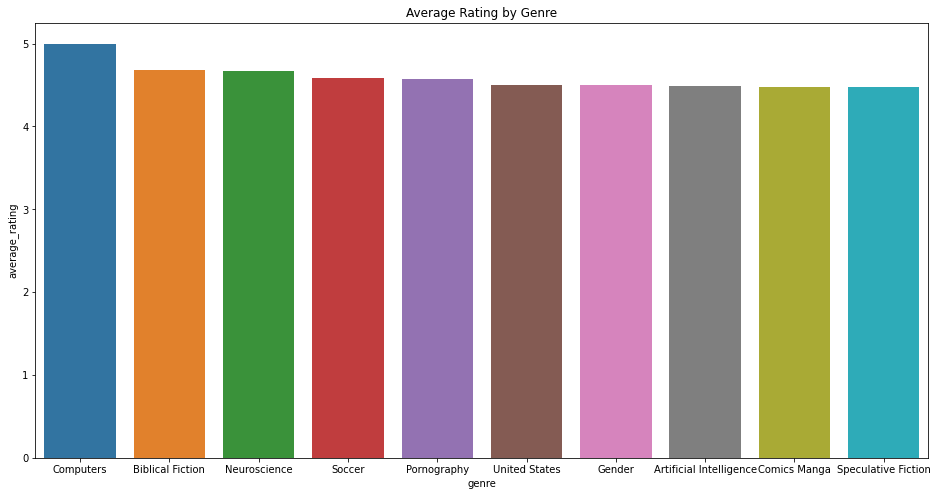

In [124]:
fig, axes = plt.subplots(1, 1, figsize=(16,8))
plt6 = sns.barplot(x = top_10_genres.index, y = 'average_rating', data = top_10_genres, orient = None)
plt6.set_title("Average Rating by Genre")
plt.savefig('chart.png')

In [86]:
sum_by_genre.head()

,rating_count,review_count,is_series,is_nominated
genre,,,,
Fantasy,184622087,8933243,5916,1623
Fiction,166423830,10260517,1287,2082
Classics,139692609,3713363,335,150
Young Adult,114452307,7173086,1846,988
Romance,56411605,3745436,3286,623


In [195]:
by_genre = mean_by_genre.join(sum_by_genre, on = 'genre')

In [196]:
by_genre.head()

,average_rating,number_of_pages,rating_count,review_count,is_series,is_nominated
genre,,,,,,
Self Help,5.000000,50.0,4,2,0,0
Computers,5.000000,50.0,2,0,0,0
Fantasy,5.000000,80.0,3,3,1,0
Biblical Fiction,4.676667,133.0,1694,373,1,2
Neuroscience,4.670000,672.0,9,1,0,0


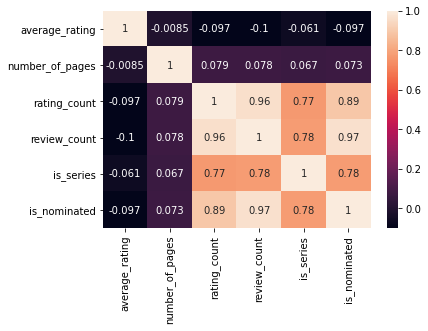

In [197]:
#plt.figure(figsize=(15,4))
corr_matrix = by_genre.corr()
sns.heatmap(corr_matrix, annot=True)

In [176]:
books.publisher = books.publisher.fillna("Unknown")

In [177]:
len(np.unique(books.publisher))

11042

In [201]:
sum_by_publisher = books.groupby('publisher').sum().sort_values('rating_count', ascending=False)[["rating_count","review_count","average_rating","number_of_pages","is_series","is_nominated"]]
sum_by_publisher.head(20)

,rating_count,review_count,average_rating,number_of_pages,is_series,is_nominated
publisher,,,,,,
Penguin Books,25711452,1098002,1986.88,1.839582e+05,148,151
"Little, Brown and Company",21155025,958295,686.79,6.589407e+04,63,75
Unknown,15219027,1088324,14933.53,1.032970e+06,1781,127
Penguin Classics,15037353,440300,1126.52,1.140491e+05,45,42
Vintage,14531298,807088,2254.05,2.067251e+05,100,239
Scholastic Press,14187970,686921,666.40,5.099407e+04,101,70
Scribner,13617858,699490,645.65,5.959707e+04,30,76
Bantam,13308250,467087,1486.77,1.476771e+05,189,82
Ballantine Books,12543243,697085,1567.32,1.620963e+05,155,122
